In [15]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from copy import deepcopy

In [16]:
import jax
import jax.numpy as np
import numpy as onp
from jax import grad, jacfwd, jacrev, jit, value_and_grad, hessian, vmap
from jax.ops import index, index_add, index_update
from scipy.stats import multivariate_normal
from jax.config import config
config.update("jax_enable_x64", True)

In [17]:
def dsample_arb_min(x, ksize):
    """
    Downsamples a ksize*n size array by ksize
    """
    size = x.shape[0]
    size_out = size//ksize

    # Dim 1
    x = x.reshape(size**2 // ksize, ksize)
    x = np.sum(x, axis=1)
    x = x.reshape(size, size//ksize)
    x = x.T

    # Dim 2
    x = x.reshape(size**2 // ksize**2, ksize)
    x = np.sum(x, axis=1)
    x = x.reshape(size//ksize, size//ksize)
    x = x.T
    return x
dsample_arb = jit(dsample_arb_min, static_argnums=(1))

def Gaussian_min(x0, y0, npix):
    """
    The Gaussian model used for the diffuser
    """
    sigma = 25
    power = 4
    c = npix/2
    xs = np.linspace(-c-x0, c-x0, npix, endpoint=False)
    ys = np.linspace(-c+y0, c+y0, npix, endpoint=False)
    X, Y = np.meshgrid(xs, ys)
    exponent = ((X)**2/(2*sigma**2) + (Y)**2/(2*sigma**2))**power
    G = np.exp(-exponent)
    G = G/np.sum(G)
    return G
Gaussian = jit(Gaussian_min, static_argnums=(2))

def model_min(x, y, model_type):
    """
    Fourier modelling code - Calls the diffuser modelling code when appropriate
    """
    aperture = 0.018
    npix = 360
    wl = 525e-9
    fl = 0.15
    pix_size = 1.12e-6
    tf_size = 512
    
    if model_type == 0:
        pupil = np.load("tol_pupil.npy")
    elif model_type == 1:
        pupil = np.load("airy_pupil.npy")
    else:
        return Gaussian(x, y, npix)

    # Calcualtions
    plate_scale = pix_size/fl    # Radians per pixel
    spatial_freq = wl/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(tf_size/scale_factor)
    phase_scale = 2 * np.pi * aperture * pix_size / fl
    fact = tf_size/size_out
    c = tf_size//2
    s = npix//2
            
    # Off axis stars, create phase slope
    r_pix = np.hypot(x, y) # Distance from off axis (pixels)
    phi_rot = np.arctan2(y, x) # Coordiante rotation angle
    delta_phase = phase_scale * r_pix / wl # Change in phase across the aperture
    eps = 0.0001
    phase_slope = np.linspace(eps, delta_phase + eps, size_out, endpoint=False)
    Xs, Ys  = np.meshgrid(phase_slope, phase_slope)
    Rs = np.hypot(Xs, Ys)
    Phis = np.arctan2(Ys, Xs)
    phase_out = Rs * np.cos(Phis + phi_rot)

    # Add phase to pupil
    pupil_phase = np.angle(pupil) + phase_out
    pupil_mag = np.abs(pupil)
    pupil_new = pupil_mag * np.exp(1j*pupil_phase)
    array_out = np.zeros((tf_size,tf_size),dtype=np.complex64)
    array_out = index_update(array_out, index[0:size_out, 0:size_out], pupil_new)

    # Perform FT
    wf = np.fft.fftshift(np.fft.fft2(array_out))
    PSF = np.abs(wf)**2
    PSF = PSF[c-s:c+s, c-s:c+s]
    PSF_out = PSF/np.sum(PSF)
    
    return PSF_out
model = jit(model_min, static_argnums=(2))

In [43]:
def gen_data_min(theta, r, saturate, model_type, ksize):
    """
    Generates the data 
    Note saturate seems to break the Fourier modelled images... not sure how they are related
    """
    star1 = 1e4 * model(theta[0], 0, model_type)
    star2 = 1e4 * model(r + theta[1], 0, model_type)
    img = star1 + star2
    img = dsample_arb(img, ksize)
#     img = np.minimum(img, saturate)
    return img
gen_data = jit(gen_data_min, static_argnums=(3, 4))

def nlp_min(theta, r, data, noise, saturate, model_type, ksize):
    """
    Negative log prior - chi squared
    """
    exp = gen_data(theta, r, saturate, model_type, ksize)
    norm_diff =  (data - exp)/noise
    chi2 = np.sum(norm_diff**2)
    return -chi2/2
nlp = jit(nlp_min, static_argnums=(5, 6))
nlp_hessian = jit(hessian(nlp), static_argnums=(5, 6))

def cov_mat_min(theta, r, noise, saturate, model_type, ksize):
    """
    Covariance matrix
    """
    data = gen_data(theta, r, saturate, model_type, ksize)
    H = nlp_hessian(theta, r, data, noise, saturate, model_type, ksize)
    return np.linalg.inv(H)
cov_mat = jit(cov_mat_min, static_argnums=(4, 5))

def get_values_min(sigma):
    """
    Extracts the eigen vectors and values from a covariance matrix
    Also returns the eigen ratios 
    """
    eigval_c, eigvec_c = np.linalg.eig(sigma)
    eigval, eigvec = np.sort(np.real(eigval_c)), np.real(eigvec_c)
    scale = np.hypot(eigval[0], eigval[1])
    ratio = eigval[0]/eigval[1]
    return eigval, eigvec, ratio, scale
get_values = jit(get_values_min)

In [44]:
# Note these parameters need to match those inside model_min
# Ie don't change them
fl = 0.15
diam = 0.018
lam = 525e-9
pix = 1.12e-6
dlim = fl * np.tan((1.22*lam)/diam)
Nyq = dlim/2
Nyquist_pix = Nyq/pix
# Nyquist_pix is the ratio between the Nyquist sampled pixels and the true pixel size

## Things of note:
 > Including saturation breaks the results of PSF modelled with Fouirer transforms (ie doesnt affect Diffuser model) even though the saturation method applied is identical in all cases 
 
 > Noise does not seem to change the result at all... How or why is beyond me - maybe the incorrect chi^2 is being applied. examples below
 
 > There appears to be some oscillatory behaviour in the covariance... this could make sense with Toliman as the peaks go from overlapping to being spread, but we see the same affect with the airy disk, maybe this is an result of the airy rings going from ovlapping to not?
 
 > The output that we are using to measure covariance is the eignevalue ratio - However as can be seen in the contour plots (ive added the eigenvectors scaled by the eigenvalues), what we would *expect* to happen (ie airy beating everything) is matched by the actual scaled eigenvector lengths. Notice how they get longer *and* the reatio increases as we get closer. Maybe we need to scale the values by actual eigenvector length.
 
 > A weird weird bug exists where you can not call a fucntion with a concrete argument input that is called as index - ie func(vals[i]) will recompile every time (ie no jit) and val = vals[i]; func(val) will compile/jit properly

---

### Lets what this returns for basic parameters

In [55]:
# Number of position samples
n = 50

# Downsampling Kernel size, keep at regular sampling
ksize = 1

# Nyquist sized pixel in downsampled image
Nyquist_pix_ksize = Nyquist_pix/ksize

# Starting seperation, 4 Nyquist pixels away
start = 2.5*Nyquist_pix_ksize 

# Ending separation - Going too close results in kernel death. I suspect from
# having too large values to compute - has been improved by using 64 bit floats
end = 1e-2 

# Sampling positions
rs = np.linspace(start, end, n, endpoint=True)

# Saturation level - This breaks both Toliman and Airy...
saturate = 1e10
# saturate = 100

# Noise level - this doesnt seem to change the results....
noise = 10

# Deviation from true value to test at - setting to zero crashed kernel
# 1e-75 seems to be as close as you can get without kernel murder
theta = np.array([1e-75, 1e-75])

# Model type
# 0 - Toliman
# 1 - Airy disk
# 2 - Diffuser
mtypes = np.array([0, 1, 2])
labels = ["Toliman", "Airy", "Diffuser"]

# Results arrays
ratios = np.zeros([len(mtypes), n]) # Eigenvalue ratios
eigvals = np.zeros([len(mtypes), 2, n]) # Eigen values
sigmas = np.zeros([len(mtypes), 2, 2, n]) # Sigma matrices
eigvecs = np.zeros([len(mtypes), 2, 2, n]) # Eigen vectors
images = np.zeros([len(mtypes), 360//ksize, 360//ksize, n]) # Images

# Generate Results
for m in range(len(mtypes)):
    for i in tqdm(range(n)):
        # Make things
        image = gen_data(theta, rs[i], saturate, mtypes[m], ksize)
        sigma = cov_mat(theta, rs[i], noise, saturate, m, ksize)
        eigval, eigvec, ratio, scale = get_values(sigma)

        # Save things
        ratios  = index_update(ratios,  index[m,       i], scale*ratio)
        eigvals = index_update(eigvals, index[m, :,    i], eigval)
        sigmas  = index_update(sigmas,  index[m, :, :, i], sigma)
        eigvecs = index_update(eigvecs, index[m, :, :, i], eigvec)
        images  = index_update(images,  index[m, :, :, i], image)

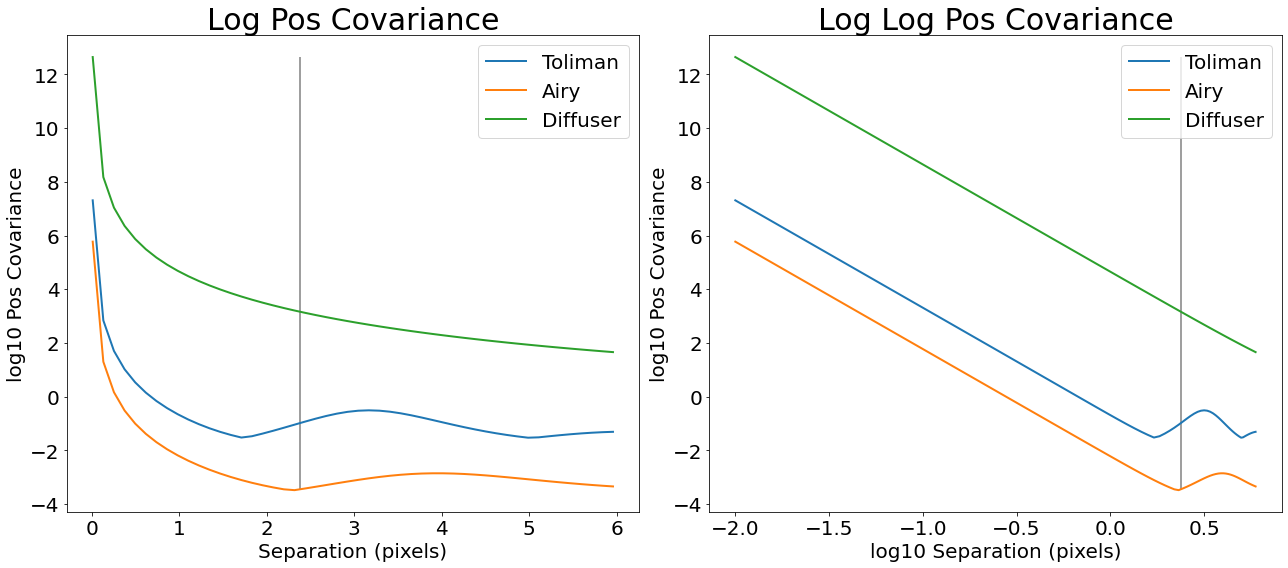

In [56]:
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(rs, np.log10(ratios[0, :]), linewidth=2, label="Toliman", c="tab:blue")
plt.plot(rs, np.log10(ratios[1, :]), linewidth=2, label="Airy", c="tab:orange")
plt.plot(rs, np.log10(ratios[2, :]), linewidth=2, label="Diffuser", c="tab:green")
plt.vlines(Nyquist_pix_ksize, np.min(np.log10(ratios)), np.max(np.log10(ratios)), alpha=0.5)
plt.xlabel("Separation (pixels)", fontsize=20)
plt.ylabel("log10 Pos Covariance", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.title("Log Pos Covariance", fontsize=30)


plt.subplot(1, 2, 2)
plt.plot(np.log10(rs), np.log10(ratios[0, :]), linewidth=2, label="Toliman", c="tab:blue")
plt.plot(np.log10(rs), np.log10(ratios[1, :]), linewidth=2, label="Airy", c="tab:orange")
plt.plot(np.log10(rs), np.log10(ratios[2, :]), linewidth=2, label="Diffuser", c="tab:green")
plt.vlines(np.log10(Nyquist_pix_ksize), np.min(np.log10(ratios)), np.max(np.log10(ratios)), alpha=0.5)
plt.xlabel("log10 Separation (pixels)", fontsize=20)
plt.ylabel("log10 Pos Covariance", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.title("Log Log Pos Covariance", fontsize=30)


plt.tight_layout()
plt.show()

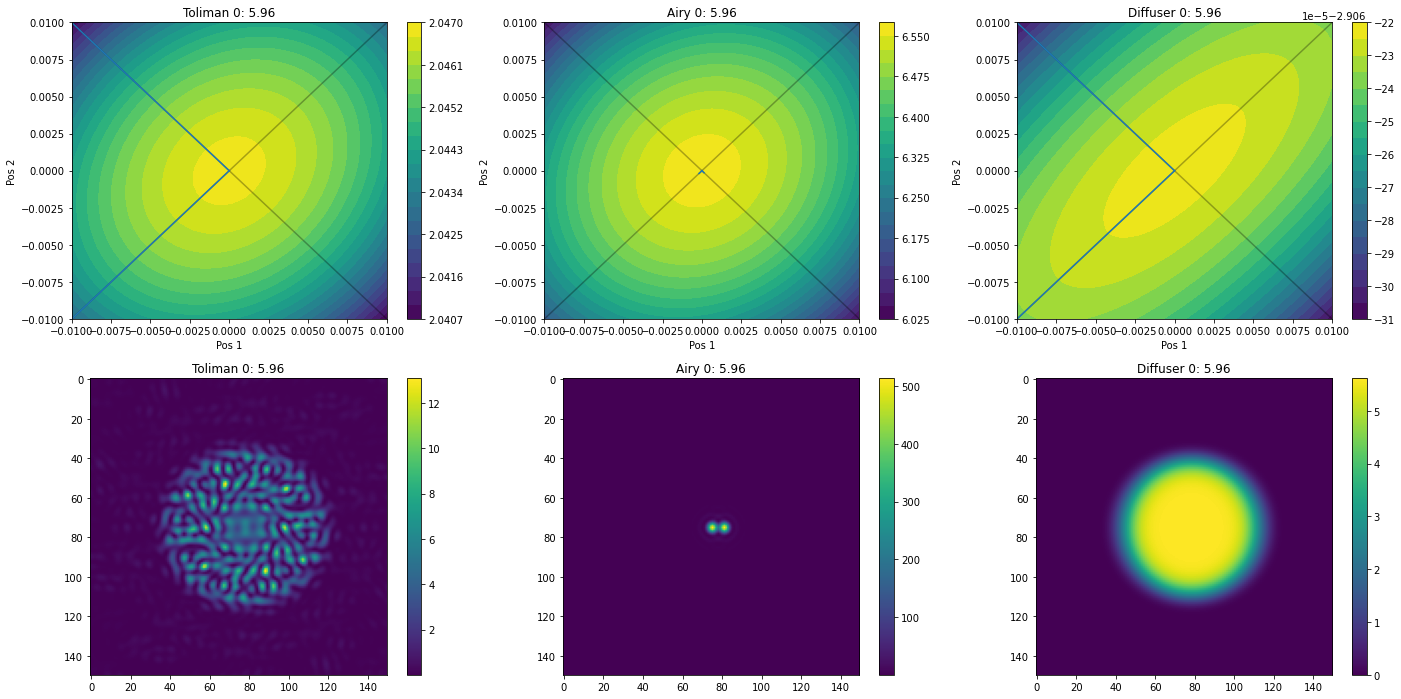

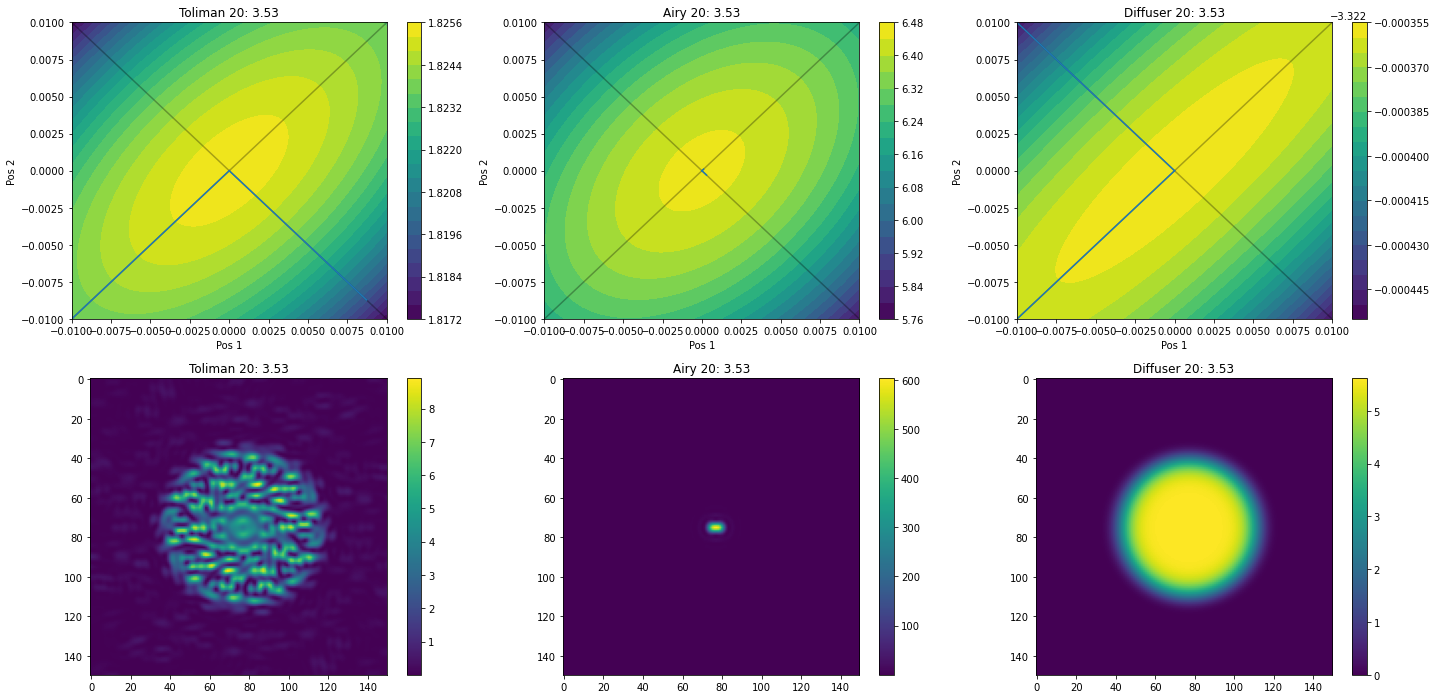

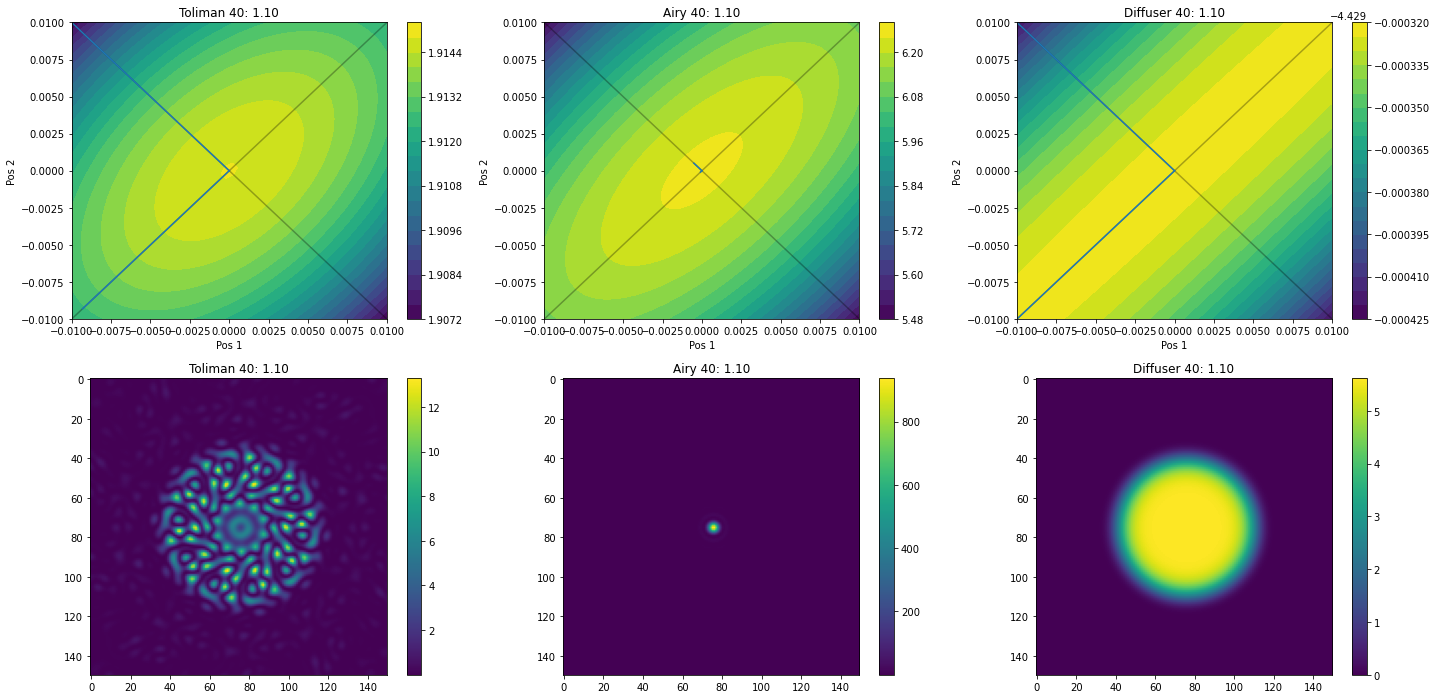

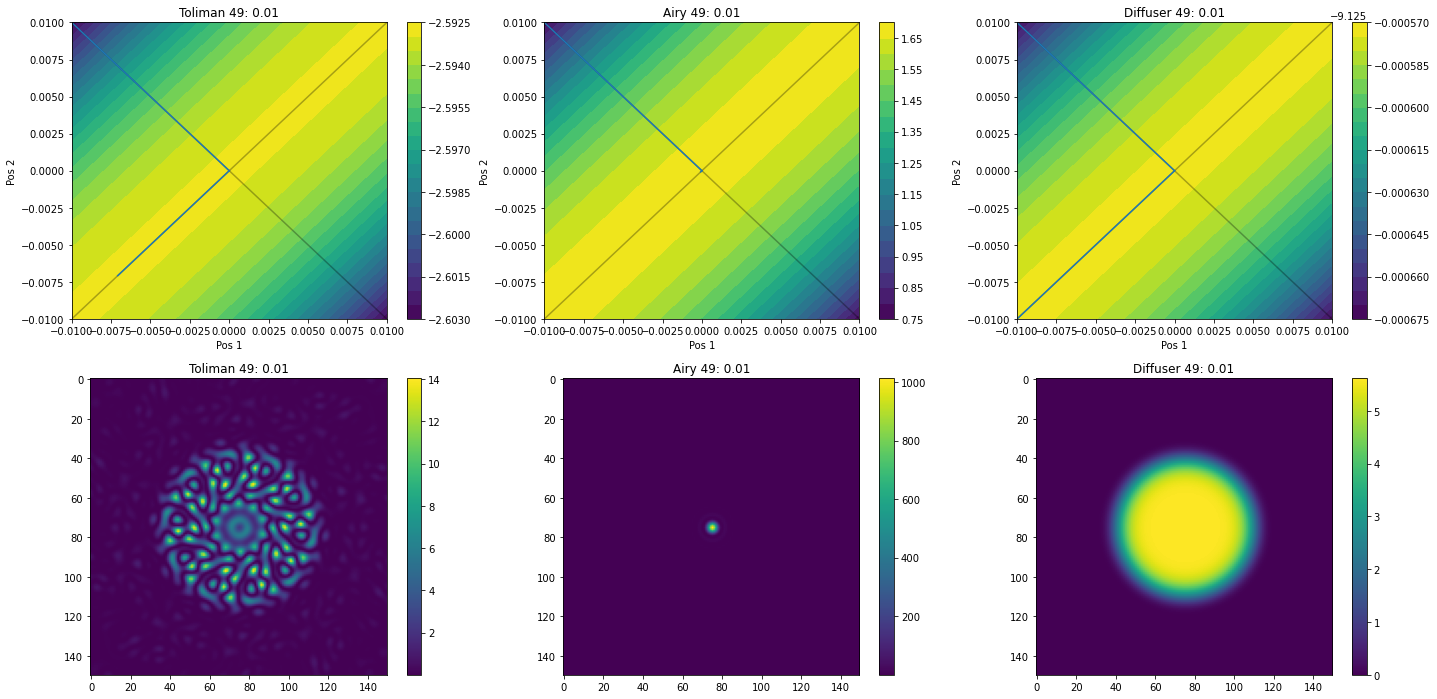

In [50]:
min_val = -1e-2
max_val = 1e-2
pos1 = np.linspace(min_val, max_val, n)
pos2 = np.linspace(min_val, max_val, n)
X, Y = np.meshgrid(pos1, pos2)
XY = np.stack((X, Y)).reshape(2, n**2).T
c = 180//ksize
s = 75

ivals = [0, 20, 40, 49]
for i in ivals:
    plt.figure(figsize=(24, 12))
    for m in range(len(mtypes)):
        Z = multivariate_normal(mean=theta, cov=np.abs(sigmas[m, :, :, i])).logpdf(XY).reshape(n, n)
        eigval = eigvals[m, :,    i]
        eigvec = eigvecs[m, :, :, i]
        xs1 = np.linspace(0, eigvec[0, 0]*eigval[0])
        ys1 = np.linspace(0, eigvec[0, 1]*eigval[0])
        xs2 = np.linspace(0, eigvec[1, 0]*eigval[1])
        ys2 = np.linspace(0, eigvec[1, 1]*eigval[1])

        # Plot contour
        plt.subplot(2, 3, m + 1)
        plt.contourf(X, Y, Z, levels=20)
        
        # Plot diagonal lines to measure skew
        plt.plot(theta[0] + pos1, theta[1] + pos1, alpha=0.3, c='k')
        plt.plot(theta[0] - pos1, theta[1] + pos1, alpha=0.3, c='k')
        
        # Plot eigenvectors
        plt.plot(theta[0] + xs1, theta[1] + ys1, c='tab:blue')
        plt.plot(theta[0] + xs2, theta[1] + ys2, c='tab:blue')

        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.title("{} {}: {:.2f}".format(labels[m], i, rs[i]))
        plt.xlabel("Pos 1")
        plt.ylabel("Pos 2")
        plt.colorbar()
    
    # plot corresponding images
    for m in range(len(mtypes)):
        plt.subplot(2, 3, m + 4)
        plt.imshow(images[m, c-s:c+s, c-s:c+s, i])
        plt.title("{} {}: {:.2f}".format(labels[m], i, rs[i]))
        plt.colorbar()
    plt.show()

In [51]:
# min_val = -1e-2
# max_val = 1e-2
# pos1 = np.linspace(min_val, max_val, n)
# pos2 = np.linspace(min_val, max_val, n)
# X, Y = np.meshgrid(pos1, pos2)
# XY = np.stack((X, Y)).reshape(2, n**2).T
# c = 180//ksize
# s = 75

# ivals = [0, 20, 40, 49]
# for i in ivals:
#     xs, ys, maxxs, maxys = [], [], [], []
#     for m in range(len(mtypes)):
#         eigval = eigvals[m, :,    i]
#         eigvec = eigvecs[m, :, :, i]
#         x1 = eigvec[0, 0]*eigval[0]
#         y1 = eigvec[0, 1]*eigval[0]
#         x2 = eigvec[1, 0]*eigval[1]
#         y2 = eigvec[1, 1]*eigval[1]
#         maxxs.append(np.max(np.abs(np.array([x1, x2]))))
#         maxys.append(np.max(np.abs(np.array([y1, y2]))))
#         xs.append(np.array([x1, x2]))
#         ys.append(np.array([y1, y2]))
        
#         lens = np.sort(np.array([np.hypot(np.abs(x1), np.abs(y1)),
#                                  np.hypot(np.abs(x2), np.abs(y2))]))
        
#         print("{} ratio, lengths:    \t{:.2f}\t\t{:.4f}\t\t{:.4f}".format(labels[m], lens[1]/lens[0], lens[1], lens[0]))
        
#     xs, ys = np.array(xs), np.array(ys)
#     plt.figure(figsize=(24, 6))
#     idx = 1
#     for m in [2, 0, 1]:
#         plt.subplot(1, 3, idx)
        
#         # Plot Diffuser eigenvectors
#         plt.plot([0, theta[0] + xs[2, 0]], [0, theta[1] + ys[2, 0]], c='tab:green')
#         plt.plot([0, theta[0] + xs[2, 1]], [0, theta[1] + ys[2, 1]], c='tab:green', label="Diffuser")
#         plt.scatter( theta[0] + xs[2, 0],      theta[1] + ys[2, 0], c='tab:green', marker='x', s=75)
#         plt.scatter( theta[0] + xs[2, 1],      theta[1] + ys[2, 1], c='tab:green', marker='x', s=75)
        
#         # Plot Toliman eigenvectors
#         plt.plot([0, theta[0] + xs[0, 0]], [0, theta[1] + ys[0, 0]], c='tab:blue')
#         plt.plot([0, theta[0] + xs[0, 1]], [0, theta[1] + ys[0, 1]], c='tab:blue', label="Toliman")
#         plt.scatter( theta[0] + xs[0, 0],      theta[1] + ys[0, 0], c='tab:blue', marker='x', s=75)
#         plt.scatter( theta[0] + xs[0, 1],      theta[1] + ys[0, 1], c='tab:blue', marker='x', s=75)

#         # Plot Airy eigenvectors
#         plt.plot([0, theta[0] + xs[1, 0]], [0, theta[1] + ys[1, 0]], c='tab:orange')
#         plt.plot([0, theta[0] + xs[1, 1]], [0, theta[1] + ys[1, 1]], c='tab:orange', label="Airy")
#         plt.scatter( theta[0] + xs[1, 0],      theta[1] + ys[1, 0], c='tab:orange', marker='x', s=75)
#         plt.scatter( theta[0] + xs[1, 1],      theta[1] + ys[1, 1], c='tab:orange', marker='x', s=75)

#         plt.legend()
#         plt.title("Scaled to {} vectors - {}: {:.2f}".format(labels[m], i, rs[i]))
#         plt.xlabel("Pos 1")
#         plt.ylabel("Pos 2")   
#         plt.xlim(-1.1*maxxs[m], 1.1*maxxs[m])
#         plt.ylim(-1.1*maxys[m], 1.1*maxys[m])
        
#         idx += 1
#     plt.show()

---

### How do the results change as a function of noise?

In [52]:
# Number of position samples
n = 25

# Downsampling Kernel size, keep at regular sampling
ksize = 1

# Nyquist sized pixel in downsampled image
Nyquist_pix_ksize = Nyquist_pix/ksize

# Starting seperation, 4 Nyquist pixels away
start = 2.5*Nyquist_pix_ksize 

# Ending separation - Going too close results in kernel death. I suspect from
# having too large values to compute - has been improved by using 64 bit floats
end = 1e-2 

# Sampling positions
rs = np.linspace(start, end, n, endpoint=True)

# Saturation level
saturate = 1e10

# Noise level - this doesnt seem to change the results....
noises = np.array([1, 10, 100, 1000])

# Deviation from true value to test at - setting to zero crashed kernel
# 1e-75 seems to be as close as you can get without kernel murder
theta = np.array([1e-75, 1e-75])

# Model type
# 0 - Toliman
# 1 - Airy disk
# 2 - Diffuser
mtypes = np.array([0, 1, 2])
labels = ["Toliman", "Airy", "Diffuser"]

# Results arrays
ratios = np.zeros([len(noises), len(mtypes), n]) # Eigenvalue ratios
eigvals = np.zeros([len(noises), len(mtypes), 2, n]) # Eigen values
sigmas = np.zeros([len(noises), len(mtypes), 2, 2, n]) # Sigma matrices
eigvecs = np.zeros([len(noises), len(mtypes), 2, 2, n]) # Eigen vectors
images = np.zeros([len(noises), len(mtypes), 360//ksize, 360//ksize, n]) # Images

# Generate Results
for j in range(len(noises)):
    for m in range(len(mtypes)):
        for i in tqdm(range(n)):
            # Make things
            image = gen_data(theta, rs[i], saturate, mtypes[m], ksize)
            sigma = cov_mat(theta, rs[i], noises[j], saturate, m, ksize)
            eigval, eigvec, ratio, scale = get_values(sigma)

            # Save things
            ratios  = index_update(ratios,  index[j, m,       i], ratio*scale)
            eigvals = index_update(eigvals, index[j, m, :,    i], eigval)
            sigmas  = index_update(sigmas,  index[j, m, :, :, i], sigma)
            eigvecs = index_update(eigvecs, index[j, m, :, :, i], eigvec)
            images  = index_update(images,  index[j, m, :, :, i], image)

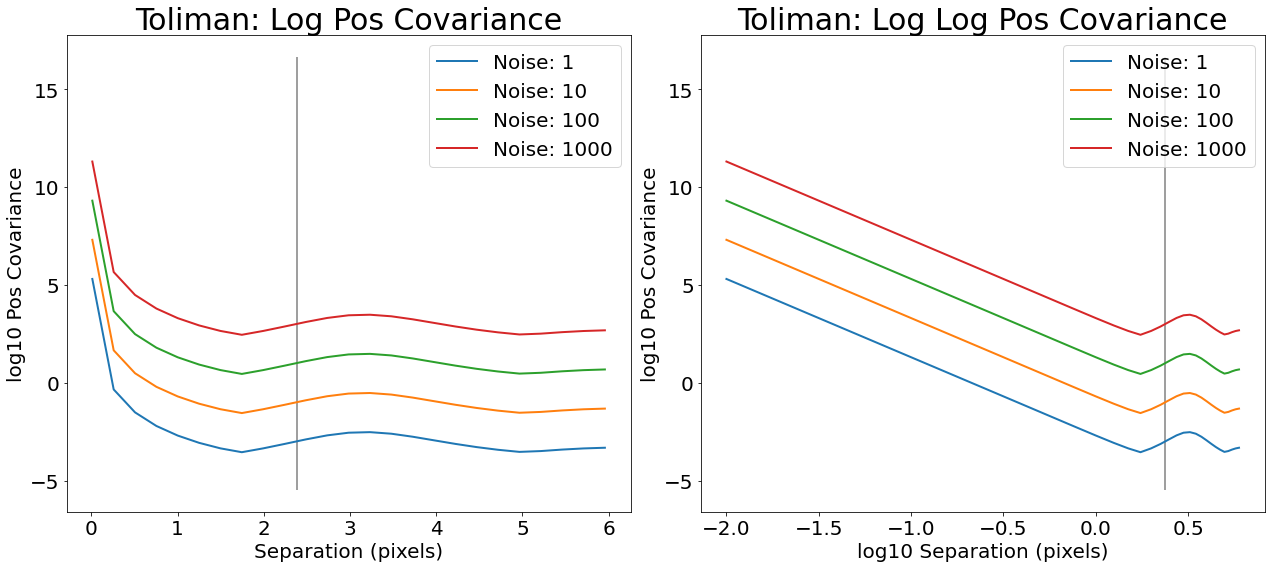

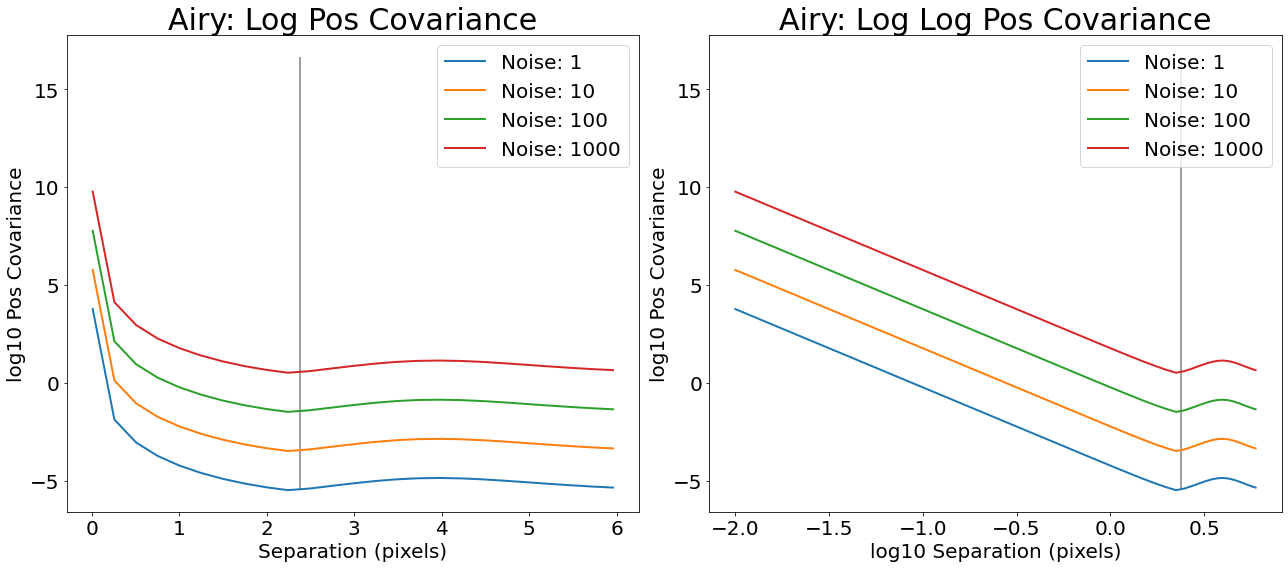

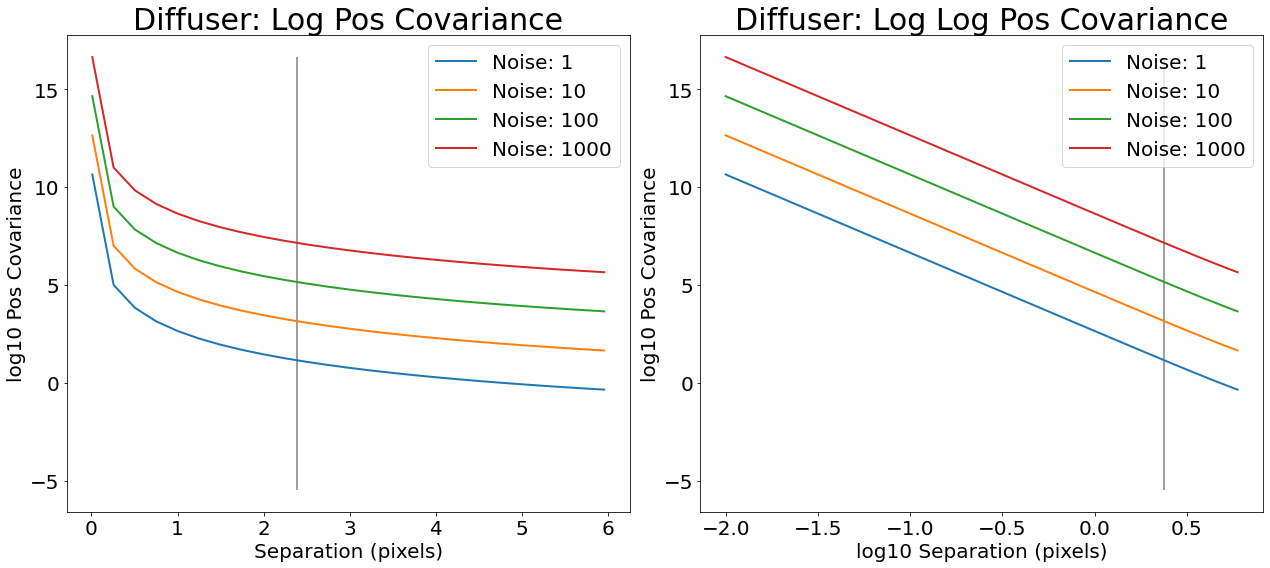

In [54]:
for m in range(len(mtypes)):
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    for j in range(len(noises)):
        plt.plot(rs, np.log10(ratios[j, m, :]), linewidth=2, label="Noise: {}".format(noises[j]))
    plt.vlines(Nyquist_pix_ksize, np.min(np.log10(ratios)), np.max(np.log10(ratios)), alpha=0.5)
    plt.xlabel("Separation (pixels)", fontsize=20)
    plt.ylabel("log10 Pos Covariance", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.title("{}: Log Pos Covariance".format(labels[m]), fontsize=30)

    plt.subplot(1, 2, 2)
    for j in range(len(noises)):
        plt.plot(np.log10(rs), np.log10(ratios[j, m, :]), linewidth=2, label="Noise: {}".format(noises[j]))
    plt.vlines(np.log10(Nyquist_pix_ksize), np.min(np.log10(ratios)), np.max(np.log10(ratios)), alpha=0.5)
    plt.xlabel("log10 Separation (pixels)", fontsize=20)
    plt.ylabel("log10 Pos Covariance", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.title("{}: Log Log Pos Covariance".format(labels[m]), fontsize=30)


    plt.tight_layout()
    plt.show()

---

### Clearly noise does not affect the result - How about sampling?

In [57]:
# Number of position samples
n = 25

# Downsampling Kernel size, keep at regular sampling
ksizes = np.array([1, 3, 9, 18])

# Nyquist sized pixel in downsampled image
Nyquist_pix_ksize = Nyquist_pix/ksize

# Starting seperation, 4 Nyquist pixels away
start = 2.5*Nyquist_pix_ksize 

# Ending separation - Going too close results in kernel death. I suspect from
# having too large values to compute - has been improved by using 64 bit floats
end = 1e-2 

# Sampling positions
rs = np.linspace(start, end, n, endpoint=True)

# Saturation level
saturate = 1e10

# Noise level - this doesnt seem to change the results....
noise = 10

# Deviation from true value to test at - setting to zero crashed kernel
# 1e-75 seems to be as close as you can get without kernel murder
theta = np.array([1e-75, 1e-75])

# Model type
# 0 - Toliman
# 1 - Airy disk
# 2 - Diffuser
mtypes = np.array([0, 1, 2])
labels = ["Toliman", "Airy", "Diffuser"]

# Results arrays
ratios = np.zeros([len(ksizes), len(mtypes), n]) # Eigenvalue ratios
eigvals = np.zeros([len(ksizes), len(mtypes), 2, n]) # Eigen values
sigmas = np.zeros([len(ksizes), len(mtypes), 2, 2, n]) # Sigma matrices
eigvecs = np.zeros([len(ksizes), len(mtypes), 2, 2, n]) # Eigen vectors
# images = np.zeros([len(ksizes), len(mtypes), 360//ksize, 360//ksize, n]) # Images

# Generate Results
for k in range(len(ksizes)):
    ksize = ksizes[k]
    for m in range(len(mtypes)):
        for i in tqdm(range(n)):
            # Make things
#             image = gen_data(theta, rs[i], saturate, mtypes[m], ksizes[k])
            sigma = cov_mat(theta, rs[i], noise, saturate, m, ksize)
            eigval, eigvec, ratio, scale = get_values(sigma)

            # Save things
            ratios  = index_update(ratios,  index[k, m,       i], ratio*scale)
            eigvals = index_update(eigvals, index[k, m, :,    i], eigval)
            sigmas  = index_update(sigmas,  index[k, m, :, :, i], sigma)
            eigvecs = index_update(eigvecs, index[k, m, :, :, i], eigvec)
#             images  = index_update(images,  index[k, m, :, :, i], image)

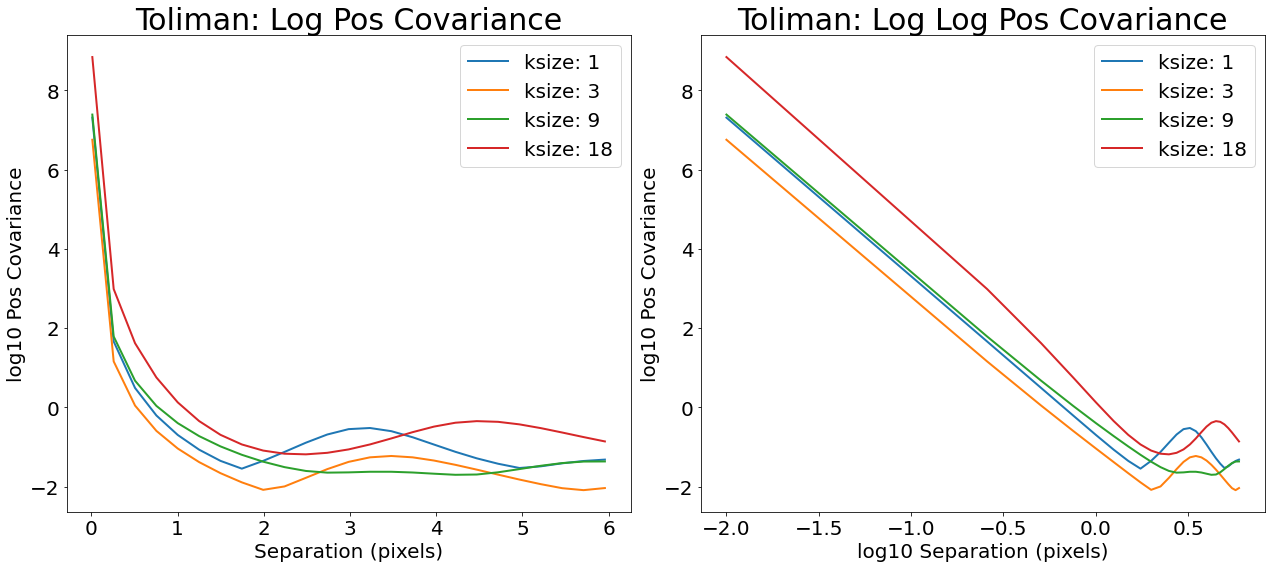

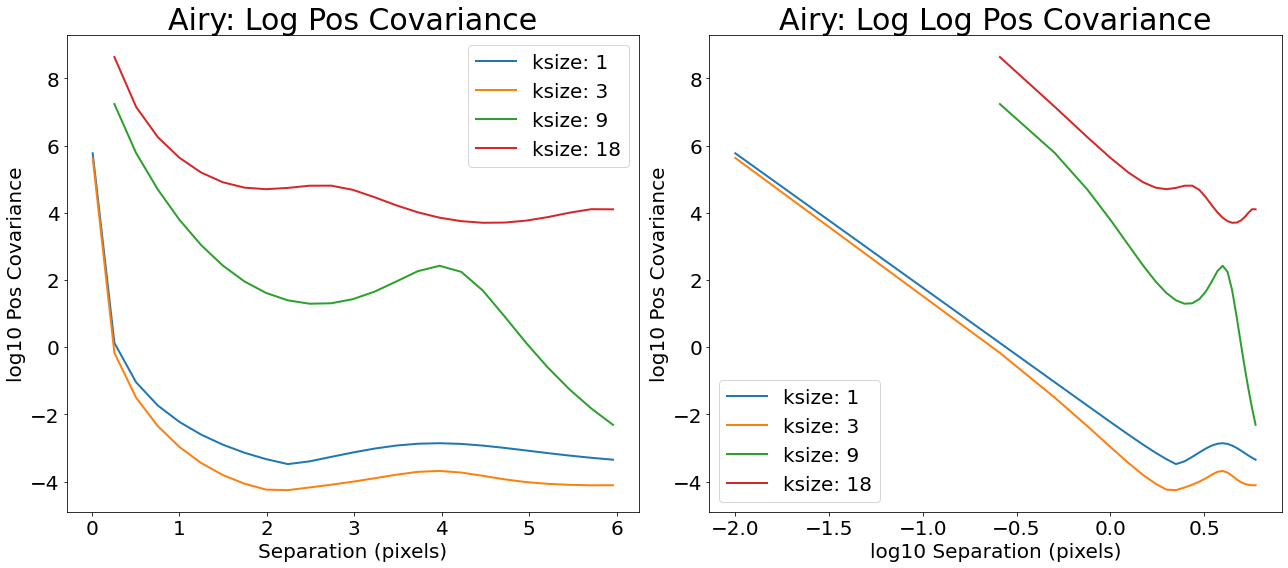

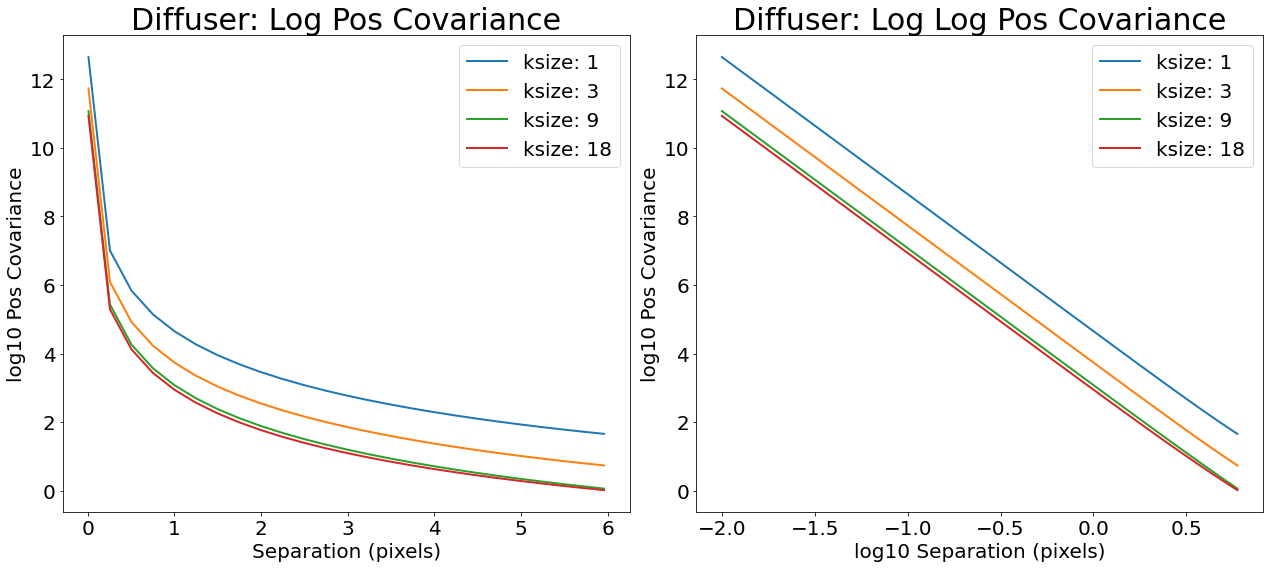

In [58]:
for m in range(len(mtypes)):
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1)
    for k in range(len(ksizes)):
        plt.plot(rs, np.log10(ratios[k, m, :]), linewidth=2, label="ksize: {}".format(ksizes[k]))
#         plt.vlines(Nyquist_pix_ksize, np.min(np.log10(ratios)), np.max(np.log10(ratios)), alpha=0.5)
    plt.xlabel("Separation (pixels)", fontsize=20)
    plt.ylabel("log10 Pos Covariance", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.title("{}: Log Pos Covariance".format(labels[m]), fontsize=30)

    plt.subplot(1, 2, 2)
    for k in range(len(ksizes)):
        plt.plot(np.log10(rs), np.log10(ratios[k, m, :]), linewidth=2, label="ksize: {}".format(ksizes[k]))
#         plt.vlines(Nyquist_pix_ksize, np.min(np.log10(ratios)), np.max(np.log10(ratios)), alpha=0.5)
    plt.xlabel("log10 Separation (pixels)", fontsize=20)
    plt.ylabel("log10 Pos Covariance", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.title("{}: Log Log Pos Covariance".format(labels[m]), fontsize=30)


    plt.tight_layout()
    plt.show()